In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import struct
import time
import pygame
from IPython.display import clear_output, display 

# MNIST Veri Seti ve MLP Giriş Formatı

MNIST veri setinde **orijinal format**, her satırın bir örneği temsil ettiği bir tablo şeklindedir:

- **Satırlar** → örnekler (resimler)  
- **Sütunlar** → her örneğin piksel değerleri  

Örneğin: `images.shape = (10000, 784)`  
- 10.000 resim  
- Her resimde 784 piksel

---

Ancak **MLP (çok katmanlı algılayıcı)** gibi yapay sinir ağları, **giriş verisini `(özellik sayısı, örnek sayısı)` formatında** bekler:

- **Satırlar** → özellikler (her piksel bir özellik)  
- **Sütunlar** → örnekler (her sütun bir resim)

Bu nedenle `images.T` (transpose) kullanılarak verinin satır ve sütunları yer değiştirildi. Sonuç olarak:

- Her sütun artık bir örnek resim  
- Her satır bir pikseli temsil ediyor

Bu dönüşüm sayesinde, ağırlık matrisi ile giriş matrisinin çarpımı **boyut olarak uyumlu** oluyor ve MLP doğru şekilde çalışabiliyor.

---

**Özetle:**

> MNIST’in satır-temelli formatını, MLP’nin ihtiyaç duyduğu sütun-temelli formata çevirdik.  
> Böylece matris çarpımları sorunsuz gerçekleşiyor ve her sütun bağımsız bir örnek olarak ağ tarafından işlenebiliyor.


In [ ]:
# MNIST resim dosyasını (el yazısı rakamlar) okuyan fonksiyon.
def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        # Dosyanın başından resim sayısını, satır ve sütun sayısını okuyoruz.
        # ">IIII": Bu bir okuma formatıdır.
        magic, num, rows, cols = struct.unpack(">IIII", f.read(16))

        # Geri kalan tüm veriyi resim pikselleri olarak alıyoruz (0-255 arası parlaklık).
        images = np.frombuffer(f.read(), dtype=np.uint8)

        # Her resmi (28x28) tek bir uzun satır (784 piksel) haline getiriyoruz.
        images = images.reshape(num, rows*cols)
        return images

# MNIST etiket dosyasını (resmin hangi rakam olduğunu) okuyan fonksiyon.
def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        # Dosyanın başından etiket sayısını okuyoruz.
        # ">II": Bu da bir okuma formatıdır.
        magic, num = struct.unpack(">II", f.read(8))

        # Geri kalan tüm veriyi resimlerin rakamları (etiketleri) olarak alıyoruz.
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels

# --- Veriyi Yüklüyoruz ---

# Resim dosyalarını ve etiket dosyalarını yüklüyoruz.
images = load_mnist_images("./t10k-images.idx3-ubyte")
labels = load_mnist_labels("./t10k-labels.idx1-ubyte")

# Yüklenen resim ve etiketlerin kaçar tane olduğunu göster.
print(images.shape)  # Çıktı: (10000, 784) -> 10000 resim, her biri 784 piksel
print(labels.shape)  # Çıktı: (10000,) -> 10000 etiket

## Veriyi Eğitim ve Test Gruplarına Ayırma ✂️
# Modeli eğitmek ve ne kadar iyi öğrendiğini test etmek için veriyi ayırıyoruz.
# İlk 1000 tanesi "Test", geri kalanı "Eğitim" için kullanılacak.

# TEST VERİSİ (Modeli denemek için)
# İlk 1000 resim ve etiketini al.
x_test = images[:1000].T # Resimleri al ve satır-sütun yerini değiştir (.T)

# Piksel değerlerini (0-255) 255'e bölerek 0 ile 1 arasına getir (Normalleştirme).
# Bu, modelin daha hızlı öğrenmesini sağlar.
x_test = x_test/255.
y_test = labels[:1000]

# EĞİTİM VERİSİ (Modeli eğitmek için)
# Kalan tüm resim ve etiketleri al (1000. sıradan sonrası).
x_train = images[1000:].T
x_train = x_train/255. # Yine normalleştirme yap.
y_train = labels[1000:]

# Son olarak, oluşan grupların boyutlarını kontrol et.
print(x_train.shape) # Eğitim resimlerinin yeni boyutu
print(y_train.shape) # Eğitim etiketlerinin yeni boyutu
print(x_test.shape)  # Test resimlerinin yeni boyutu
print(y_test.shape)  # Test etiketlerinin yeni boyutu

# Açıklama: MLP Parametreleri, İleri ve Geri Yayılım

Bu bölümde, çok katmanlı bir algılayıcı (MLP) için temel adımları görüyoruz:

1. **Parametrelerin Başlatılması (`init_params`)**

   * Ağırlıklar rastgele küçük değerlerle başlatılıyor.
   * Biaslar da rastgele seçiliyor.
   * Katman boyutları girişten çıkışa doğru tanımlanıyor: 784 → 128 → 64 → 32 → 10

2. **Aktivasyon Fonksiyonları (`relu` ve `softmax`)**

   * `relu`: Negatif değerleri 0’a çeviriyor, pozitifleri olduğu gibi bırakıyor.
   * `relu_deriv`: Backprop sırasında kullanılıyor, sadece aktif nöronların gradini geçiriyor.
   * `softmax`: Çıkış katmanı için olasılık dağılımı oluşturuyor, tüm olasılıkların toplamı 1 oluyor.

3. **İleri Yayılım (`forward_prop`)**

   * Giriş verisi katman katman işleniyor.
   * Her katmanda ağırlıklı toplam + bias hesaplanıyor, aktivasyon fonksiyonuna gönderiliyor.
   * Çıkışta softmax ile tahmin olasılıkları elde ediliyor.

4. **One-Hot Kodlama (`one_hot`)**

   * Etiketleri sinir ağının anlayacağı forma çeviriyoruz.
   * Örneğin, "3" etiketi → `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`

5. **Geri Yayılım (`backward_prop`)**

   * Hata, çıkıştan girişe doğru katman katman aktarılıyor.
   * Her katman için ağırlık ve bias gradyanları hesaplanıyor.
   * `relu_deriv` ile sadece aktif nöronlar için gradyan geçiyor.

6. **Parametre Güncelleme (`update_params`)**

   * Hesaplanan gradyanlara göre ağırlık ve biaslar güncelleniyor.
   * Öğrenme oranı (`alpha`) ile ne kadar değişiklik yapılacağını kontrol ediyoruz.

> Kısaca: Bu kod, MLP’nin temel döngüsünü oluşturuyor. İleri yayılım tahmin yapıyor, geri yayılım hatayı hesaplıyor ve parametreleri güncelleyerek modelin öğrenmesini sağlıyor.

# Aktivasyon Fonksiyonu: ReLU (Rectified Linear Unit)

## ReLU Neden Kullanılır ve Ne İşe Yarar?

Yapay sinir ağlarında, bir katmandan gelen çıktıları bir sonraki katmana iletmeden önce bir **Aktivasyon Fonksiyonundan** geçiririz.

**ReLU (Düzeltilmiş Doğrusal Birim)**, bu fonksiyonlar arasında en popüler olanıdır. Temel amacı, sinir ağına **doğrusallık dışı (non-linearity)** özellik katmaktır. Bu özellik olmadan, ağ ne kadar derin olursa olsun (ne kadar katman eklerseniz ekleyin), sadece düz bir çizgi (lineer bir denklem) çizebilir.

ReLU, basitliği sayesinde:

1.  **Hesaplama Hızı:** Çok hızlı ve kolay hesaplanır.
2.  **Seyreklik (Sparsity):** Negatif değerleri sıfırlayarak ağın seyrekleşmesini sağlar, bu da öğrenmeyi kolaylaştırır.

-----

## 1\. ReLU Fonksiyonu (İleri Yayılım)

ReLU, giriş değeri ($x$) için basit bir kural uygular: **Eğer giriş pozitifse, olduğu gibi geçir; eğer negatifse, sıfır yap.**

**Matematiksel Tanım:**

$$\operatorname {ReLU} (x)= \max(0,x)$$

Veya Parçalı Fonksiyon Olarak:

$$\operatorname{ReLU} (x)= {\begin{cases}x&{\text{if }}x>0,\\0&x\leq 0\end{cases}}$$

**Python Kodu ile Uygulanışı:**

```python
def relu(X):
    # X'teki her elemanı 0 ile karşılaştırır ve büyük olanı döndürür.
    return np.maximum(X, 0)
```

-----

## 2\. ReLU Türevi (Geri Yayılım - Backpropagation)

Sinir ağının öğrenmesi (ağırlıkların güncellenmesi) **Geri Yayılım (Backpropagation)** ile gerçekleşir. Bu süreçte, hatanın geriye doğru yayılması için aktivasyon fonksiyonunun **türevine** ihtiyacımız vardır.

**ReLU'nun Türevi** de tıpkı kendisi gibi çok basittir: **Giriş pozitifse 1, negatif veya sıfırsa 0.**

**Matematiksel Türev Tanımı:**

$$\operatorname{ReLU}'(x) = {\begin{cases}1 & \text{if } x > 0 \\0 & \text{if } x \le 0\end{cases}}$$

**Python Kodu ile Uygulanışı:**

```python
def relu_deriv(Z):
    # Python'da True=1, False=0 demektir.
    # Bu ifade, Z'nin pozitif olduğu yerlerde 1, diğer yerlerde 0 döndürür.
    return Z > 0
```

In [ ]:
def relu(X):
    return np.maximum(X, 0)

def relu_deriv(Z):
    return Z > 0

# Softmax: Sonuçları Olasılıklara Çevir\!

## Softmax Ne Yapar ve Neden Lazım?

Yapay zeka modelimiz bir resme baktıktan sonra, her bir rakam için bir "güven puanı" verir. Softmax'ın görevi, bu ham puanları alıp, bizim anlayacağımız **kesin olasılıklara** çevirmektir.

  * **Görevi:** Modelin tahminlerini, toplamı **%100 (yani 1)** olan olasılıklara dönüştürmek.
  * **Sonuç:** Modelin hangi sınıfa ne kadar inandığını net bir şekilde gösterir.

**Örnek:** Modelin "7" olma puanı yüksekse, Softmax o çıktıya en büyük olasılığı (%90 gibi) verir.

-----

## 1\. Softmax Fonksiyonu (Hesaplama Adımı)

Softmax, yüksek puana sahip olanı diğerlerine göre çok daha fazla öne çıkarır.

**Matematiksel Formül:**

$$\sigma (\mathbf {z} )_{i}={\frac {e^{z_{i}}}{\sum _{j=1}^{K}e^{z_{j}}}}$$

  * **$z_i$**: Sınıf $i$'nin (örneğin rakam 7'nin) aldığı ham puandır.
  * **$e^{z_i}$**: Puanın kuvveti alınarak pozitif yapılır ve değeri büyütülür (güçlendirilir).
  * **$\sum _{j=1}^{K}e^{z_{j}}$**: Tüm sınıfların ($K$ tane) güçlendirilmiş puanlarının toplamıdır (payda).

**⚠️ Önemli Not (Kararlılık):**
Kodda gördüğünüz `np.max(X)` çıkarma işlemi, büyük puanlar nedeniyle bilgisayarın hata vermesini (sayının sonsuza ulaşmasını) engellemek için yapılır. Bu, formülün pratik uygulamada **daha güvenli** çalışması için bir hiledir\! 

In [ ]:
def softmax(X):
    e_x = np.exp(X - np.max(X))
    return e_x / e_x.sum(axis=0)

# One-Hot Encoding:\!

## Bu Fonksiyon Neden Gerekli?

Yapay zeka modelimiz (sinir ağımız), tahmin yaparken çıktı olarak 10 farklı nöron kullanır (her biri 0'dan 9'a kadar bir rakam için).

Bizim elimizdeki etiketler ise sadece tek bir sayıdır. Örneğin, "Bu resim **7**" veya "Bu resim **3**".

**Problem:** Eğer modele sadece "7" dersek, model bu sayıyı **bir değer** olarak algılar. Yani yanlışlıkla 7'nin 1'den 7 kat daha önemli olduğunu düşünebilir. 🙅‍♀️

**One-Hot Çözümü:** Bu fonksiyon, elimizdeki tek sayıyı, içinde sadece **bir tane 1** olan uzun bir "cevap kartına" çevirir.

| Orijinal Etiket | Cevap Kartı (10 Kutucuk) | Anlamı |
| :---: | :---: | :--- |
| **3** | `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]` | 3. kutucukta **EVET (1)** var. Diğerleri HAYIR (0). |
| **7** | `[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]` | 7. kutucukta **EVET (1)** var. |

Bu sayede model, "3" ve "7"nin sadece **farklı seçenekler** olduğunu anlar. ✅

-----

## 1\. One-Hot Fonksiyonu (Adım Adım Kodlama)

Bu kod, etiketleri ($Y$), modelin eğitilmesi için uygun olan **cevap kartı** formatına çevirir.

In [ ]:
def one_hot(Y):
    # 1. Sıfırlardan oluşan bir matris oluştur
    # (Y.size: örnek sayısı, Y.max() + 1: sınıf sayısı (0'dan başladığı için +1))
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    
    # 2. Karşılık gelen sütunlara 1 değerini atama
    # Y.size: tüm satırları seç
    # Y: her satır için hangi sütunun 1 olacağını belirler
    one_hot_Y[np.arange(Y.size), Y] = 1
    
    # 3. Boyutları sinir ağına uygun hale getirme (Transpoze)
    # (Sınıf sayısı x Örnek sayısı
    one_hot_Y = one_hot_Y.T

    return one_hot_Y

# init\_params():

## Bu Fonksiyon Ne Yapar?

Bir yapay sinir ağı, öğrenmeye başlamadan önce **ağırlıklara (W)** ve **sapmalara (b)** ihtiyaç duyar. Bunlar, ağın bir katmandan diğerine bilgi taşırken kullanacağı temel sayılardır.

  * **Ağırlıklar (W):** Giriş verisinden gelen her bilginin **önemini** belirleyen sayılardır (Matris).
  * **Sapmalar (b):** Her nöronun tek başına ürettiği **ekstra bir değerdir** (Vektör).

Bu fonksiyon, bu ağırlık ve sapmaları **rastgele** sayılarla başlatır.

## Ağımızın Yapısı (4 Katmanlı)

Modelimiz 4 katmandan oluşmaktadır. Her katman, bir önceki katmandan gelen bilgiyi işler:

| Katman | Giriş Nöronu | Çıkış Nöronu | Amacı |
| :---: | :---: | :---: | :--- |
| **Giriş** | 784 | - | Her resimdeki 784 piksel. |
| **Gizli 1** | 784 | 128 | Veriyi küçültmeye başlar. |
| **Gizli 2** | 128 | 64 | Daha fazla desen öğrenir. |
| **Gizli 3** | 64 | 32 | En karmaşık desenleri çıkarır. |
| **Çıkış** | 32 | **10** | Sonuçta 0'dan 9'a kadar 10 sınıfı tahmin eder. |

-----

## 1\. init\_params Fonksiyonu (Başlatma)

Bu kod, her bir katmanın ağırlık (W) ve sapma (b) matrislerini rastgele sayılarla doldurur.

In [ ]:
def init_params():
    
    # 📝 Not: np.random.rand(...) - 0.5 kullanmamızın sebebi,
    # ağırlıkların hem pozitif hem de negatif sayılarla başlamasını sağlamaktır.

    # 👉 Gizli Katman 1: 784 pikseli 128 nörona bağlar
    W1 = np.random.rand(128, 784) - 0.5 # W1: (128 satır, 784 sütun)
    b1 = np.random.rand(128, 1) - 0.5  # b1: (128 satır, 1 sütun)
    
    # 👉 Gizli Katman 2: 128 nöronu 64 nörona bağlar
    W2 = np.random.rand(64, 128) - 0.5 # W2: (64 satır, 128 sütun)
    b2 = np.random.rand(64, 1) - 0.5   # b2: (64 satır, 1 sütun)
    
    # 👉 Gizli Katman 3: 64 nöronu 32 nörona bağlar
    W3 = np.random.rand(32, 64) - 0.5  # W3: (32 satır, 64 sütun)
    b3 = np.random.rand(32, 1) - 0.5   # b3: (32 satır, 1 sütun)
    
    # 👉 Çıkış Katmanı: 32 nöronu 10 nihai cevaba (0'dan 9'a) bağlar
    W4 = np.random.rand(10, 32) - 0.5  # W4: (10 satır, 32 sütun)
    b4 = np.random.rand(10, 1) - 0.5   # b4: (10 satır, 1 sütun)
    
    # Tüm bu parçaları fonksiyonun sonucu olarak geri gönder.
    return W1, b1, W2, b2, W3, b3, W4, b4

# Yapay Sinir Ağı Eğitim Döngüsü (Forward & Backward)

## 1\. İleri Yayılım (Forward Propagation)

İleri Yayılım, verinin **ağın başından (giriş)** sonuna **(tahmin)** doğru tek yönlü hareketidir. Bu aşamada model, elindeki ağırlıkları kullanarak tahmin yapar.

  * **Amaç:** Giriş resmini ($X$) alıp, katmanlar aracılığıyla işleyerek nihai tahmini (Softmax çıktısı $a4$) üretmektir.
  * **Adımlar:** Her katmanda iki temel işlem yapılır:
    1.  **Ağırlıklı Toplam ($z$):** Girişler, ağırlıklarla çarpılıp sapma ($b$) eklenir. ($W \cdot A + b$)
    2.  **Aktivasyon ($a$):** $z$ sonucu, bir sonraki katmana gitmeden önce ReLU (ve son katmanda Softmax) fonksiyonundan geçirilir.

-----

## 2\. Geri Yayılım (Backward Propagation)

Geri Yayılım, modelin yaptığı hatayı bularak bu hatanın **ağın sonundan (tahmin)** başına doğru geri yayılmasıdır. Bu, modelin hangi ağırlıkları ne kadar değiştirmesi gerektiğini belirler.

  * **Amaç:** Tahmin edilen değer ($a4$) ile doğru etiket ($Y$) arasındaki farkı (hata/gradyan) hesaplamak ve bu farkı her katmanın ağırlıklarına dağıtmaktır.
  * **Adımlar:**
    1.  Son katmanda hata ($dz4$) hesaplanır: $\text{Tahmin} - \text{Gerçek Etiket}$.
    2.  Hata, zincirleme kuralı kullanılarak geriye doğru her katmana iletilir ($dz3, dz2, dz1$).
    3.  Her katmanda, ağırlıkların ($dW$) ve sapmaların ($db$) ne kadar değişmesi gerektiği hesaplanır.

-----

## 3\. Parametre Güncelleme (Update Parameters)

Bu son adımda, Geri Yayılım ile hesaplanan gradyanlar ($dW$ ve $db$) kullanılarak ağın ağırlıkları ve sapmaları gerçekten değiştirilir. Bu, ağın **öğrenme** eylemidir.

  * **Amaç:** Ağırlıkları, hatayı azaltacak yönde küçük adımlarla değiştirmektir.
  * **Öğrenme Oranı ($\alpha$):** Değişimin ne kadar hızlı (büyük adımlarla) yapılacağını kontrol eden önemli bir ayardır.

In [ ]:
def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X):
    # Katman 1
    z1 = W1.dot(X) + b1
    a1 = relu(z1)
    
    # Katman 2
    z2 = W2.dot(a1) + b2
    a2 = relu(z2)
    
    # Katman 3
    z3 = W3.dot(a2) + b3
    a3 = relu(z3)
    
    # Katman 4 (Çıkış)
    z4 = W4.dot(a3) + b4 # W4 * A3 + B4
    a4 = softmax(z4)     # Z4'ü (ağırlıklı toplam) Softmax'e vermeliyiz

    return z1, a1, z2, a2, z3, a3, z4, a4

def backward_prop(z1, a1, z2, a2, z3, a3, z4, a4, W1, W2, W3, W4, X, Y):
    # m, örnek sayısıdır
    _, m = X.shape
    one_hot_Y = one_hot(Y) # one_hot fonksiyonunuzun tanımlı olduğunu varsayıyorum

    # Katman 4 -> Katman 3
    dz4 = a4 - one_hot_Y
    # HATA DÜZELTİLDİ: dW4 için A3 kullanılmalı
    dw4 = 1 / m * dz4.dot(a3.T)
    # İYİLEŞTİRME: db4 için boyut koruması eklendi
    db4 = 1 / m * np.sum(dz4, axis=1, keepdims=True)

    # Katman 3 -> Katman 2
    dz3 = W4.T.dot(dz4) * relu_deriv(z3)
    dw3 = 1 / m * dz3.dot(a2.T)
    db3 = 1 / m * np.sum(dz3, axis=1, keepdims=True)

    # Katman 2 -> Katman 1
    dz2 = W3.T.dot(dz3) * relu_deriv(z2)
    # HATA DÜZELTİLDİ: dw2 için A1 kullanılmalı (Bu zaten doğruydu, bir önceki kontrol hataydı, ama burada L1 aktivasyonu doğru)
    dw2 = 1 / m * dz2.dot(a1.T) 
    db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)

    # Katman 1 -> Giriş (X=A0)
    dz1 = W2.T.dot(dz2) * relu_deriv(z1)
    dw1 = 1 / m * dz1.dot(X.T)
    db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)

    return dw1, db1, dw2, db2, dw3, db3, dw4, db4

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, dw1, db1, dw2, db2, dw3, db3, dw4, db4, alpha):
    # Gizli Katman 1 (W1, b1) güncelleniyor:
    # Ağırlık W1, öğrenme oranı (alpha) * gradyan (dw1) kadar azaltılır.
    W1 = W1 - alpha * dw1
    # Sapma b1, öğrenme oranı (alpha) * gradyan (db1) kadar azaltılır.
    b1 = b1 - alpha * db1

    # Gizli Katman 2 (W2, b2) güncelleniyor:
    W2 = W2 - alpha * dw2
    b2 = b2 - alpha * db2
    
    # Gizli Katman 3 (W3, b3) güncelleniyor:
    W3 = W3 - alpha * dw3
    b3 = b3 - alpha * db3

    # Çıkış Katmanı (W4, b4) güncelleniyor:
    W4 = W4 - alpha * dw4
    b4 = b4 - alpha * db4

    # Tüm güncellenmiş parametreleri döndür.
    return W1, b1, W2, b2, W3, b3, W4, b4

# Temel Fonksiyonlar ve Eğitim Çekirdeği

In [ ]:
def init_params():
    # Gizli Katman 1: 784 -> 128
    W1 = np.random.rand(128, 784) - 0.5
    b1 = np.random.rand(128, 1) - 0.5
    
    # Gizli Katman 2: 128 -> 64
    W2 = np.random.rand(64, 128) - 0.5
    b2 = np.random.rand(64, 1) - 0.5
    
    # Gizli Katman 3: 64 -> 32
    W3 = np.random.rand(32, 64) - 0.5
    b3 = np.random.rand(32, 1) - 0.5
    
    # Çıkış Katmanı: 32 -> 10
    W4 = np.random.rand(10, 32) - 0.5
    b4 = np.random.rand(10, 1) - 0.5
    
    return W1, b1, W2, b2, W3, b3, W4, b4

def relu(X):
    return np.maximum(X, 0)

def relu_deriv(Z):
    return Z > 0

def softmax(X):
    e_x = np.exp(X - np.max(X))
    return e_x / e_x.sum(axis=0)

def forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X):
    # Katman 1
    z1 = W1.dot(X) + b1
    a1 = relu(z1)
    
    # Katman 2
    z2 = W2.dot(a1) + b2
    a2 = relu(z2)
    
    # Katman 3
    z3 = W3.dot(a2) + b3
    a3 = relu(z3)
    
    # Katman 4 (Çıkış)
    z4 = W4.dot(a3) + b4 # W4 * A3 + B4
    a4 = softmax(z4)     # Z4'ü (ağırlıklı toplam) Softmax'e vermeliyiz

    return z1, a1, z2, a2, z3, a3, z4, a4

def one_hot(Y):
    # 1. Sıfırlardan oluşan bir matris oluştur
    # (Y.size: örnek sayısı, Y.max() + 1: sınıf sayısı (0'dan başladığı için +1))
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    
    # 2. Karşılık gelen sütunlara 1 değerini atama
    # Y.size: tüm satırları seç
    # Y: her satır için hangi sütunun 1 olacağını belirler
    one_hot_Y[np.arange(Y.size), Y] = 1
    
    # 3. Boyutları sinir ağına uygun hale getirme (Transpoze)
    # (Sınıf sayısı x Örnek sayısı
    one_hot_Y = one_hot_Y.T

    return one_hot_Y

def backward_prop(z1, a1, z2, a2, z3, a3, z4, a4, W1, W2, W3, W4, X, Y):
    # m, örnek sayısıdır
    _, m = X.shape
    one_hot_Y = one_hot(Y) # one_hot fonksiyonunuzun tanımlı olduğunu varsayıyorum

    # Katman 4 -> Katman 3
    dz4 = a4 - one_hot_Y
    # HATA DÜZELTİLDİ: dW4 için A3 kullanılmalı
    dw4 = 1 / m * dz4.dot(a3.T)
    # İYİLEŞTİRME: db4 için boyut koruması eklendi
    db4 = 1 / m * np.sum(dz4, axis=1, keepdims=True)

    # Katman 3 -> Katman 2
    dz3 = W4.T.dot(dz4) * relu_deriv(z3)
    dw3 = 1 / m * dz3.dot(a2.T)
    db3 = 1 / m * np.sum(dz3, axis=1, keepdims=True)

    # Katman 2 -> Katman 1
    dz2 = W3.T.dot(dz3) * relu_deriv(z2)
    # HATA DÜZELTİLDİ: dw2 için A1 kullanılmalı (Bu zaten doğruydu, bir önceki kontrol hataydı, ama burada L1 aktivasyonu doğru)
    dw2 = 1 / m * dz2.dot(a1.T) 
    db2 = 1 / m * np.sum(dz2, axis=1, keepdims=True)

    # Katman 1 -> Giriş (X=A0)
    dz1 = W2.T.dot(dz2) * relu_deriv(z1)
    dw1 = 1 / m * dz1.dot(X.T)
    db1 = 1 / m * np.sum(dz1, axis=1, keepdims=True)

    return dw1, db1, dw2, db2, dw3, db3, dw4, db4

def update_params(W1, b1, W2, b2, W3, b3, W4, b4, dw1, db1, dw2, db2, dw3, db3, dw4, db4, alpha):
    # Gizli Katman 1 (W1, b1) güncelleniyor:
    # Ağırlık W1, öğrenme oranı (alpha) * gradyan (dw1) kadar azaltılır.
    W1 = W1 - alpha * dw1
    # Sapma b1, öğrenme oranı (alpha) * gradyan (db1) kadar azaltılır.
    b1 = b1 - alpha * db1

    # Gizli Katman 2 (W2, b2) güncelleniyor:
    W2 = W2 - alpha * dw2
    b2 = b2 - alpha * db2
    
    # Gizli Katman 3 (W3, b3) güncelleniyor:
    W3 = W3 - alpha * dw3
    b3 = b3 - alpha * db3

    # Çıkış Katmanı (W4, b4) güncelleniyor:
    W4 = W4 - alpha * dw4
    b4 = b4 - alpha * db4

    # Tüm güncellenmiş parametreleri döndür.
    return W1, b1, W2, b2, W3, b3, W4, b4

# Sinir Ağının Öğrenme Yönetimi: Gradyan İnişi

Bu kod bloğu, modelin tahmin yapmasından öğrenme döngüsünün yönetimine kadar tüm süreci kapsar:

* **Tahmin Çıkarma (`get_predictions`):**
    * Modelin Softmax'ten aldığı olasılık puanları arasından **en yüksek olana sahip olanı** nihai tahmin olarak seçer.

* **Başarı Ölçümü (`get_accuracy`):**
    * Yapılan tahminleri, gerçek cevaplarla karşılaştırır ve modelin **doğruluk yüzdesini** hesaplar. Bu, öğrenmenin ne kadar başarılı olduğunu gösterir.

* **Ana Eğitim Döngüsü (`gradient_descent`):**
    * Tüm süreci yöneten ana fonksiyondur.
    * İlk olarak rastgele ağırlıkları (`init_params`) başlatır.
    * Belirlenen tekrar sayısı boyunca sürekli olarak:
        * **İleri Yayılım** ile tahmin yapar.
        * **Geri Yayılım** ile hatayı bulup düzeltme miktarını hesaplar.
        * **Parametre Güncelleme** ile ağırlıkları düzelterek modeli geliştirir.

Bu döngü, modelin hata yapa yapa öğrenmesini sağlayan **Gradyan İnişi** algoritmasını uygular.

In [ ]:
def get_predictions(a4):
    return np.argmax(a4, 0)

def get_accuracy(p, Y):
    print(p, Y)
    return np.sum(p == Y) /Y.size

def gradient_descent(X, Y, iterations, alpha):

    W1, b1, W2, b2, W3, b3, W4, b4 = init_params()

    for i in range(iterations):
        z1, a1, z2, a2, z3, a3, z4, a4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X)
        dw1, db1, dw2, db2, dw3, db3, dw4, db4 = backward_prop(z1, a1, z2, a2, z3, a3, z4, a4, W1, W2, W3, W4, X, Y)
        W1, b1, W2, b2, W3, b3, W4, b4 = update_params(W1, b1, W2, b2, W3, b3, W4, b4, dw1, db1, dw2, db2, dw3, db3, dw4, db4, alpha)

        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ",  get_accuracy(get_predictions(a4), Y))
        
    return W1, b1, W2, b2, W3, b3, W4, b4

# Eğitimi Başlatma

In [ ]:
W1, b1, W2, b2, W3, b3, W4, b4 = gradient_descent(x_train, y_train, 500 ,0.05)

# Tek Tek Tahminleri Görme ve Görselleştirme:

Bu kod, eğitilmiş sinir ağının test verisi üzerinde **canlı performansını** görmeye yarar.

1.  **`make_predictions`:** Seçilen **tek bir resim** üzerinde ileri yayılım (`forward_prop`) yaparak tahmin üretir ve bu resmi, **gerçek etiketi** ile **modelin tahminini** yan yana gösteren bir grafik olarak çizer.
2.  **Döngü (`for`):** Bu fonksiyonu art arda çalıştırarak, modelin **ilk birkaç resimdeki** tahminini sırayla ekranda sergiler. Her resmi gösterdikten sonra kısa bir süre bekler.

**Amaç:** Modelin ne öğrendiğini ve hatalarını (varsa) görsel olarak anında kontrol etmektir.

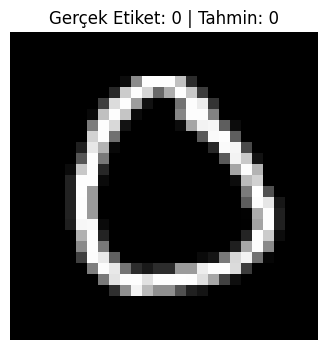

In [ ]:
def make_predictions(X_data, index, W1, b1, W2, b2, W3, b3, W4, b4, y_train):
    X_single = X_data[:, index, None] 
        
    _, _, _, _, _, _, _, A4 = forward_prop(W1, b1, W2, b2, W3, b3, W4, b4, X_single)
    prediction = np.argmax(A4, 0) 
    
    fig = plt.figure(figsize=(4, 4))
    image_to_show = X_single.reshape((28, 28)) * 255
    
    plt.gray()
    plt.imshow(image_to_show, interpolation='nearest')
    plt.title(f"Gerçek Etiket: {y_train[index]} | Tahmin: {prediction[0]}") 
    plt.axis('off')
    
    return prediction

i = 10
for i in range(i):
    
    clear_output(wait=True) 
    gercek_etiket = y_train[i]
    
    tahmin = make_predictions(x_train, i, W1, b1, W2, b2, W3, b3, W4, b4, y_train)
    
    display(plt.gcf())
    plt.close()
    time.sleep(2)
    i += 1

# MLP Sınıfı: Neden Sınıf Tabanlı Yapı Kullanıldı?

Bu kod bloğu, daha önceki parça parça fonksiyonları (`forward_prop`, `backward_prop` vb.) tek bir **`mlp` (Çok Katmanlı Algılayıcı)** **Sınıfı** altında toplayan, organize ve profesyonel bir yapıdır.

## Bu Yapının Eski Fonksiyonlardan Farkı ve Geliştirilen Yönleri

### 1. Esneklik: İstenen Sayıda Katman Oluşturma

* **Önceki Kod:** Gizli katman sayısı (W1, W2, W3, W4) **sabit** ve kod içine elle yazılmıştı.
* **Sınıf Kodunuz:** **Gizli katman sayısını istediğiniz gibi ayarlayabilirsiniz** (`hidding_layer_size` parametresi). `params` metodu, bu sayıya göre gerekli tüm ağırlık ve sapmaları (`self.weight`, `self.bias` listeleri) otomatik olarak oluşturur. Bu, kodu önemli ölçüde esnek yapar.

### 2. Otomatik Yönetim ve Temizlik 

* **Önceki Kod:** `forward_prop` gibi fonksiyonlara her seferinde tüm ağırlıkları tek tek (W1, b1, W2, b2, ...) göndermeniz gerekiyordu.
* **Sınıf Kodunuz:** Tüm ağırlıklar ve ara sonuçlar (`self.weight`, `self.activated_output`) sınıfın içinde saklanır. Metotlar (`forward_prop`, `backward_prop`) bu değişkenlere doğrudan erişir, bu sayede fonksiyon çağrıları çok daha temiz ve basitleşir.

### 3. Tek Çatı Altında Eğitim (`train`)

* Modelin kurulumu, eğitimi ve tahmin yapması (başlangıçtan sona kadar tüm adımlar) tek bir **`mlp` nesnesi** tarafından yönetilir.
* **`train()`** metodunu çağırmanız, modelin öğrenmesi için yeterlidir; tüm ileri yayılım, hata hesaplama ve düzeltme adımları otomatik olarak çalışır.

**Özetle:** Sınıf yapısı, modeli sadece çalıştıran fonksiyonlar olmaktan çıkarıp, **kendi kendine yeten, esnek katmanlı ve yönetilebilir bir Yapay Zeka Nesnesine** dönüştürür.

In [ ]:
class mlp:

    def __init__(self, x_train, y_train, hidding_layer_size, epoch ,lr):

        self.x_train = x_train
        self.y_train = y_train
        self.hidding_layer_size = hidding_layer_size
        self.epoch = epoch
        self.lr = lr

        self.weight = []
        self.dWeight = []
        self.bias = []
        self.dbias = []
        self.linear_output = []
        self.activated_output = []
        self.accuracies = []

        self.params()

    def relu(self, X):
        return np.maximum(X, 0)

    def relu_deriv(self, Z):
        return (Z > 0).astype(float)


    def softmax(self, X):
        e_x = np.exp(X - np.max(X, axis=0, keepdims=True))
        return e_x / e_x.sum(axis=0)
    
    def one_hot(self, Y):
        one_hot_Y = np.zeros((Y.size, Y.max() + 1))
        one_hot_Y[np.arange(Y.size), Y] = 1
        return one_hot_Y.T

    def params(self):

        input_size = self.x_train.shape[0]
        output_size = len(np.unique(self.y_train))

        H_max = int(2 ** np.floor(np.log2(input_size))) 
        H_hesaplanan = 32 * (2 ** (self.hidding_layer_size - 1))
        H_start = min(H_hesaplanan, H_max) 

        for _ in range(self.hidding_layer_size):
            self.weight.append(np.random.randn(H_start, input_size) * np.sqrt(2 / input_size)) 
            self.bias.append(np.zeros((H_start, 1)))

            input_size = H_start
            H_start = max(16, int(H_start / 2)) 

        self.weight.append(np.random.randn(output_size, input_size) * np.sqrt(2 / input_size)) 
        self.bias.append(np.zeros((output_size, 1)))

    def forward_prop(self,):
        X = self.x_train
        self.linear_output = []
        self.activated_output = []

        for i in range(len(self.weight)):
            z = self.weight[i].dot(X) + self.bias[i]
            self.linear_output.append(z)
            X = self.softmax(z) if i == len(self.weight) - 1 else self.relu(z)
            self.activated_output.append(X)

    def backward_prop(self):
        _, m = self.x_train.shape
        dz_ = self.activated_output[-1] - self.one_hot(self.y_train)

        self.dWeight = [None] * len(self.weight)
        self.dbias = [None] * len(self.bias)

        for i in reversed(range(len(self.weight))):
            a_prev = self.x_train if i == 0 else self.activated_output[i-1]

            self.dWeight[i] = 1 / m * dz_.dot(a_prev.T)
            self.dbias[i] = 1 / m * np.sum(dz_, axis=1, keepdims=True)

            if i != 0:
                dz_ = self.weight[i].T.dot(dz_) * self.relu_deriv(self.linear_output[i-1])

    def update_params(self):
        for i in range(len(self.weight)):
            self.weight[i] = self.weight[i] - self.lr * self.dWeight[i]
            self.bias[i] = self.bias[i] - self.lr * self.dbias[i]

    def get_accuracy(self):
        p = np.argmax(self.activated_output[-1] , 0)
        Y = self.y_train
        return np.mean(p == Y)

    def train(self):
        for i in range(self.epoch):
            self.forward_prop()
            self.backward_prop()
            self.update_params()
            if i % 10 == 0:
                acc = self.get_accuracy()
                self.accuracies.append(acc)
                print(f"Iteration: {i}, Accuracy: {acc:.4f}")
    
    def make_predictions(self, num_samples=10):
        for i in range(num_samples):
            X = self.x_train[:, i, None]
            for j in range(len(self.weight)):
                z = self.weight[j].dot(X) + self.bias[j]
                X = self.softmax(z) if j == len(self.weight) - 1 else self.relu(z)
            pred = np.argmax(X, 0)[0]

            plt.imshow(self.x_train[:, i].reshape(28, 28), cmap='gray')
            plt.title(f"Gerçek: {self.y_train[i]} | Tahmin: {pred}")
            plt.axis('off')
            clear_output(wait=True)
            display(plt.gcf())
            plt.close()
            time.sleep(1)
             
a = mlp(x_train, y_train, 5, 250, 0.01)
a.train()
a.make_predictions()